## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

!pip install swifter
import swifter

import seaborn as sns

from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16506 sha256=0059e507b32cc4b0cf83af67c61b3fb9e5882bb19e087fb9f29e192b757a4e62
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter


In [2]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
# change the display properties of pandas to max
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
data_folder = '/content/drive/MyDrive/Automatic Ticket Classification/complaints.json'

In [6]:
# Opening JSON file
f = open(data_folder) # Write the path to your data file and load it

# returns JSON object as
# a dictionary
data = json.load(f)
df = pd.json_normalize(data)

In [7]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


## Data preparation

In [8]:
# Inspect the dataframe to understand the given data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [9]:
#print the column names
print(df.columns.values)

['_index' '_type' '_id' '_score' '_source.tags' '_source.zip_code'
 '_source.complaint_id' '_source.issue' '_source.date_received'
 '_source.state' '_source.consumer_disputed' '_source.product'
 '_source.company_response' '_source.company' '_source.submitted_via'
 '_source.date_sent_to_company' '_source.company_public_response'
 '_source.sub_product' '_source.timely' '_source.complaint_what_happened'
 '_source.sub_issue' '_source.consumer_consent_provided']


In [10]:
#Assign new column names

df.rename(
    columns = {
        '_index' : 'index',
        '_type' : 'type',
        '_id' : 'id',
        '_score' : 'score',
        '_source.tags' : 'tags',
        '_source.zip_code' : 'zip_code',
        '_source.complaint_id' : 'complaint_id',
        '_source.issue' : 'issue',
        '_source.date_received' : 'date_received',
        '_source.state' : 'state',
        '_source.consumer_disputed' : 'consumer_disputed',
        '_source.product' : 'product',
        '_source.company_response' : 'company_response',
        '_source.company' : 'company',
        '_source.submitted_via' : 'submitted_via',
        '_source.date_sent_to_company' : 'date_sent_to_company',
        '_source.company_public_response' : 'company_public_response',
        '_source.sub_product' : 'sub_product',
        '_source.timely' : 'timely',
        '_source.complaint_what_happened' : 'complaint_what_happened',
        '_source.sub_issue' : 'sub_issue',
        '_source.consumer_consent_provided' : 'consumer_consent_provided'
    },
    inplace=True
  )


In [11]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace('', np.nan, inplace=True)

In [12]:
# Null values count after replacing blanks with nan in complaints column
df['complaint_what_happened'].isnull().sum()

57241

In [13]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)

In [14]:
# Null values count after removing nan in complaints column
df['complaint_what_happened'].isnull().sum()

0

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [15]:
# Write your function here to clean the text and remove all the unnecessary elements.

def clean_text(text):
  text = text.lower()  #convert to lower case
  text = re.sub(r'^\[[\w\s]\]+$', ' ', text) #Remove text in square brackets
  text = re.sub(r'[^\w\s]', ' ', text) #Remove punctuation
  text = re.sub(r'^[a-zA-Z]\d+\w*$', ' ', text) #Remove words with numbers
  return text

In [16]:
#Write your function to Lemmatize the texts

stopwords = nlp.Defaults.stop_words

def lemmatization(texts):
    lemma_sentences = []
    for doc in tqdm(nlp.pipe(texts)):
        sent = [token.lemma_ for token in doc if token.text not in set(stopwords)]
        lemma_sentences.append(' '.join(sent))
    return lemma_sentences


# def lemmatization(text):
#     tokens = word_tokenize(text)
#     wordnet_lemmetizer = WordNetLemmatizer()
#     lemmatized = [wordnet_lemmetizer.lemmatize(token) for token in tokens]
#     lemmatized_str = " ".join(lemmatized)
#     return lemmatized_str


In [17]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = pd.DataFrame()

# df_clean = pd.DataFrame({'complaints' : df['complaint_what_happened'].apply(clean_text), 'complaints_lemmatized' : df['complaint_what_happened'].apply(lemmatization)})

# clean text complaint column
df_clean['complaint_what_happened'] = df['complaint_what_happened'].apply(clean_text)

# lemmatized text columns
df_clean['complaint_what_happened_lemmatized'] = lemmatization(df_clean['complaint_what_happened'])


21072it [10:52, 32.30it/s]


In [18]:
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n 2018 write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help
2,i upgraded my xxxx xxxx card in xx xx 2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx xx xxxx to xx xx xxxx without my consent xxxx has the recording of the agent who was misled me,upgrade xxxx xxxx card xx xx 2018 tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xx xx xxxx xx xx xxxx consent xxxx recording agent mislead
10,chase card was reported on xx xx 2019 however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report xx xx 2019 fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant
11,on xx xx 2018 while trying to book a xxxx xxxx ticket i came across an offer for 300 00 to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than 10minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than 10mins after putting in the application on xx xx 2018 notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on xx xx 2018 this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,xx xx 2018 try book xxxx xxxx ticket come offer 300 00 apply ticket apply reward card information offer minute notify screen decision immediately contact xxxx refer chase bank immediately contact chase bank 10minute get notification screen tell chase representative speak application deny state ask information xxxx offer explain approve credit offer get apply account statement purchase ticket explicitly tell glad get deny absolutely long interested account ask application withdraw representative oblige happen later 10mins put application xx xx 2018 notwithstanding explicit request proceed application contrary tell chase representative chase fact ahead open credit account xx xx 2018 report credit report chase refuse

In [19]:
# Adding product & sub_product columns as category & sub-category columns to the df_clean as it can help us with more context of the itopic

df_clean['category'] = df['product']
df_clean['sub_category'] = df['sub_product']


In [20]:
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,category,sub_category
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n 2018 write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,Debt collection,Credit card debt
2,i upgraded my xxxx xxxx card in xx xx 2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx xx xxxx to xx xx xxxx without my consent xxxx has the recording of the agent who was misled me,upgrade xxxx xxxx card xx xx 2018 tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xx xx xxxx xx xx xxxx consent xxxx recording agent mislead,Credit card or prepaid card,General-purpose credit card or charge card
10,chase card was reported on xx xx 2019 however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report xx xx 2019 fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant,"Credit reporting, credit repair services, or other personal consumer reports",Other personal consumer report
11,on xx xx 2018 while trying to book a xxxx xxxx ticket i came across an offer for 300 00 to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than 10minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than 10mins after putting in the application on xx xx 2018 notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on xx xx 2018 this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,xx xx 2018 try book xxxx xxxx ticket come offer 300 00 apply ticket apply reward card information offer minute notify screen decision immediately contact xxxx refer chase bank immediately contact chase bank 10minute get notification screen tell chase representative speak application deny state ask information xxxx offer explain approve credit offer get apply account statement purchase ticket explicitly tell glad get deny absolutely long interested account ask application withdraw re

In [21]:
#Write your function to extract the POS tags

def pos_tag(text):
    # write your code here
    pos_sentences = []
    for doc in tqdm(nlp.pipe(text)):
        sent = [token.text for token in doc if token.tag_ == 'NN']
        pos_sentences.append(' '.join(sent))
    return pos_sentences


df_clean["complaint_POS_removed"] = pos_tag(df_clean['complaint_what_happened_lemmatized'])  #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


# def pos_tag(text):
#     # write your code here
#     pos_sentences = []
#     doc = nlp(text)
#     sent = [token.text for token in doc if token.tag_ == 'NN']
#     pos_sentences.append(' '.join(sent))
#     return pos_sentences


# df_clean["complaints_POS_removed"] = df_clean['complaints_lemmatized'].swifter.apply(lambda x : pos_tag(x))  #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


21072it [05:00, 70.18it/s]


In [22]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,category,sub_category,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n 2018 write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,Debt collection,Credit card debt,morning help bank service write chase debt verification statement bank validate debt mail month attempt debt information consumer chase account xxxx help
2,i upgraded my xxxx xxxx card in xx xx 2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx xx xxxx to xx xx xxxx without my consent xxxx has the recording of the agent who was misled me,upgrade xxxx xxxx card xx xx 2018 tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xx xx xxxx xx xx xxxx consent xxxx recording agent mislead,Credit card or prepaid card,General-purpose credit card or charge card,card agent upgrade anniversary date change agent information order upgrade account xxxx anniversary date xxxx consent agent
10,chase card was reported on xx xx 2019 however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report xx xx 2019 fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant,"Credit reporting, credit repair services, or other personal consumer reports",Other personal consumer report,chase card report application submit identity consent service credit verify identity applicant
11,on xx xx 2018 while trying to book a xxxx xxxx ticket i came across an offer for 300 00 to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than 10minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than 10mins after putting in the application on xx xx 2018 notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on xx xx 2018 this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,xx xx 2018 try book xxxx xxxx ticket come offer 300 00 apply ticket apply reward card inform

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [23]:
# Write your code here to visualise the data according to the 'Complaint' character length

df_clean['complaint_length'] = df_clean['complaint_what_happened'].str.len()
df_clean['complaint_what_happened_lemmatized_length'] = df_clean['complaint_what_happened_lemmatized'].str.len()
df_clean['complaint_POS_removed_length'] = df_clean['complaint_POS_removed'].str.len()

fig = go.Figure()
fig.add_trace(go.Histogram(x=df_clean['complaint_length'], name='Complaint'))
fig.add_trace(go.Histogram(x=df_clean['complaint_what_happened_lemmatized_length'], name='Complaint Lemmatized'))
fig.add_trace(go.Histogram(x=df_clean['complaint_POS_removed_length'], name='Complaint POS Removed'))
fig.update_layout(barmode='overlay', title='Complaint Character Length', xaxis_title='Character Length', yaxis_title='Count')
fig.update_traces(opacity=0.75)
fig.show()


#### Find the top 40 words by frequency among all the articles after processing the text.

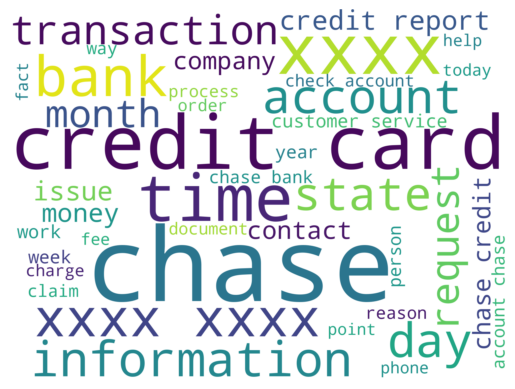

In [24]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

from wordcloud import WordCloud
wordcloud = WordCloud(stopwords=stopwords, background_color='white', width=2000, height=1500,max_words=40).generate(' '.join(df_clean['complaint_POS_removed']))
plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
plt.axis("off")
plt.show()

In [25]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [26]:
# function to get the specified top n-grams
def fetch_top_n_words(corpus, n=None, count=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:count]

def print_top_n_words(n_gram, count=0, n_gram_type=None):
    n_gram_dict = {
        1 : 'Uni',
        2 : 'Bi',
        3 : 'Tri'
    }
    for word, freq in n_gram[:count]:
        print(word, freq)
    fig = px.bar(x=[word for word, freq in n_gram[:count]], y=[freq for word, freq in n_gram[:count]], title=f'Top {count} {n_gram_dict[n_gram_type]}grams')
    fig.show()

In [27]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
unigram = fetch_top_n_words(df_clean['Complaint_clean'], n=1, count=30)

In [28]:
#Print the top 10 words in the unigram frequency
print_top_n_words(unigram, count=10, n_gram_type=1)

chase 58460
xxxx 52900
account 43065
credit 33912
card 30137
payment 21329
bank 19978
time 16233
charge 15387
day 13243


In [29]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
bigram = fetch_top_n_words(df_clean['Complaint_clean'], n=2, count=30)

In [30]:
#Print the top 10 words in the bigram frequency
print_top_n_words(bigram, count=10, n_gram_type=2)

credit card 12862
xxxx xxxx 6127
credit report 3927
chase credit 3170
customer service 3004
call chase 2956
chase bank 2579
account chase 2507
check account 2349
chase account 2114


In [31]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
trigram = fetch_top_n_words(df_clean['Complaint_clean'], n=3, count=30)

In [32]:
#Print the top 10 words in the trigram frequency
print_top_n_words(trigram, count=10, n_gram_type=3)

chase credit card 2275
xxxx xxxx xxxx 1713
credit card account 1061
credit card company 977
xxxx credit card 825
credit card chase 762
chase customer service 579
credit card xxxx 550
inquiry credit report 472
credit card credit 411


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [33]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx', '')

In [34]:
# All masked texts has been removed
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,category,sub_category,complaint_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,Complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n 2018 write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,Debt collection,Credit card debt,morning help bank service write chase debt verification statement bank validate debt mail month attempt debt information consumer chase account xxxx help,486,311,153,morning help bank service write chase debt verification statement bank validate debt mail month attempt debt information consumer chase account help
2,i upgraded my xxxx xxxx card in xx xx 2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx xx xxxx to xx xx xxxx without my consent xxxx has the recording of the agent who was misled me,upgrade xxxx xxxx card xx xx 2018 tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xx xx xxxx xx xx xxxx consent xxxx recording agent mislead,Credit card or prepaid card,General-purpose credit card or charge card,card agent upgrade anniversary date change agent information order upgrade account xxxx anniversary date xxxx consent agent,355,229,123,card agent upgrade anniversary date change agent information order upgrade account anniversary date consent agent
10,chase card was reported on xx xx 2019 however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report xx xx 2019 fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant,"Credit reporting, credit repair services, or other personal consumer reports",Other personal consumer report,chase card report application submit identity consent service credit verify identity applicant,224,149,94,chase card report application submit identity consent service credit verify identity applicant
11,on xx xx 2018 while trying to book a xxxx xxxx ticket i came across an offer for 300 00 to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than 10minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than 10mins after putting in the application on xx xx 2018 notwithstanding my explic

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [35]:
#Write your code here to initialise the TfidfVectorizer
tfidf_vec = TfidfVectorizer(max_df=0.98, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [36]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf_vec.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [37]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [38]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 # write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) # write your code here

In [39]:
nmf_model.fit(dtm)
len(tfidf_vec.get_feature_names_out())

6257

In [40]:
#Print the Top15 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print(f'The Top 15 Words for Topic #{index}')
    print([tfidf_vec.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

The Top 15 Words for Topic #0
['claim', 'customer', 'transaction', 'business', 'number', 'transfer', 'day', 'branch', 'fund', 'chase', 'deposit', 'money', 'bank', 'check', 'account']


The Top 15 Words for Topic #1
['service', 'time', 'reason', 'application', 'month', 'point', 'purchase', 'year', 'limit', 'score', 'account', 'balance', 'chase', 'credit', 'card']


The Top 15 Words for Topic #2
['date', 'statement', 'balance', 'property', 'rate', 'pay', 'year', 'time', 'home', 'modification', 'month', 'chase', 'mortgage', 'loan', 'payment']


The Top 15 Words for Topic #3
['dispute', 'letter', 'score', 'theft', 'remove', 'file', 'identity', 'account', 'reporting', 'debt', 'information', 'company', 'credit', 'inquiry', 'report']


The Top 15 Words for Topic #4
['statement', 'time', 'email', 'contact', 'service', 'fraud', 'purchase', 'refund', 'claim', 'merchant', 'transaction', 'chase', 'fee', 'dispute', 'charge']




In [41]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_values = nmf_model.transform(dtm)
topic_values.argmax(axis=1)

array([0, 1, 3, ..., 3, 1, 2])

In [42]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_values.argmax(axis=1) # write your code to assign topics to each rows.

In [43]:
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,category,sub_category,complaint_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n 2018 write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,Debt collection,Credit card debt,morning help bank service write chase debt verification statement bank validate debt mail month attempt debt information consumer chase account xxxx help,486,311,153,morning help bank service write chase debt verification statement bank validate debt mail month attempt debt information consumer chase account help,0
2,i upgraded my xxxx xxxx card in xx xx 2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx xx xxxx to xx xx xxxx without my consent xxxx has the recording of the agent who was misled me,upgrade xxxx xxxx card xx xx 2018 tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xx xx xxxx xx xx xxxx consent xxxx recording agent mislead,Credit card or prepaid card,General-purpose credit card or charge card,card agent upgrade anniversary date change agent information order upgrade account xxxx anniversary date xxxx consent agent,355,229,123,card agent upgrade anniversary date change agent information order upgrade account anniversary date consent agent,1
10,chase card was reported on xx xx 2019 however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report xx xx 2019 fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant,"Credit reporting, credit repair services, or other personal consumer reports",Other personal consumer report,chase card report application submit identity consent service credit verify identity applicant,224,149,94,chase card report application submit identity consent service credit verify identity applicant,3
11,on xx xx 2018 while trying to book a xxxx xxxx ticket i came across an offer for 300 00 to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than 10minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than 10mins after putting in the application on xx xx 2018 notwithstandi

In [44]:
#Print the first 5 Complaint for each of the Topics

df_clean.groupby('Topic').head(5).sort_values('Topic')

# df_clean = df_clean.groupby('Topic').head(5)
# df_clean.sort_values('Topic')

,complaint_what_happened,complaint_what_happened_lemmatized,category,sub_category,complaint_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n 2018 write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,Debt collection,Credit card debt,morning help bank service write chase debt verification statement bank validate debt mail month attempt debt information consumer chase account xxxx help,486,311,153,morning help bank service write chase debt verification statement bank validate debt mail month attempt debt information consumer chase account help,0
14,my grand son give me check for 1600 00 i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen xx xx 2018 check number xxxx claim number is xxxx with chase,grand son check 1600 00 deposit chase account fund clear chase bank close account pay money say need speek grand son check clear money take chase bank refuse pay money grand son call chase 2 time tell verify check owner country time date happen xx xx 2018 check number xxxx claim number xxxx chase,Checking or savings account,Checking account,son deposit chase account fund bank account pay money speek son money bank money son call chase time check owner country time date number xxxx claim number chase,477,304,161,son deposit chase account fund bank account pay money speek son money bank money son call chase time check owner country time date number claim number chase,0
17,with out notice j p morgan chase restricted my account by my debit card tuesday xx xx 2019 on thursday xx xx 2019 i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday xx xx 2019 upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement ive been called and i was told that it may take two business day stating tuesday xx xx xxxx would be the date that my funds would be available to withdraw from a bank teller only now chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently unfortunately this has put me in an additional financial bind do two fees from late rent late car payments etc i am not being a short or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a susp

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [45]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
}
# Replace Topics with Topic Names
df_clean.loc[:, 'Topic'] = df_clean['Topic'].map(Topic_names)

In [46]:
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,category,sub_category,complaint_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n 2018 write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,Debt collection,Credit card debt,morning help bank service write chase debt verification statement bank validate debt mail month attempt debt information consumer chase account xxxx help,486,311,153,morning help bank service write chase debt verification statement bank validate debt mail month attempt debt information consumer chase account help,Bank Account services
2,i upgraded my xxxx xxxx card in xx xx 2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx xx xxxx to xx xx xxxx without my consent xxxx has the recording of the agent who was misled me,upgrade xxxx xxxx card xx xx 2018 tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xx xx xxxx xx xx xxxx consent xxxx recording agent mislead,Credit card or prepaid card,General-purpose credit card or charge card,card agent upgrade anniversary date change agent information order upgrade account xxxx anniversary date xxxx consent agent,355,229,123,card agent upgrade anniversary date change agent information order upgrade account anniversary date consent agent,Credit card or prepaid card
10,chase card was reported on xx xx 2019 however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report xx xx 2019 fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant,"Credit reporting, credit repair services, or other personal consumer reports",Other personal consumer report,chase card report application submit identity consent service credit verify identity applicant,224,149,94,chase card report application submit identity consent service credit verify identity applicant,Theft/Dispute Reporting
11,on xx xx 2018 while trying to book a xxxx xxxx ticket i came across an offer for 300 00 to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than 10minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [47]:
#Create the dictionary again of Topic names and Topics

Topic_names = {
    'Bank Account services' : 0,
    'Credit card or prepaid card' : 1,
    'Others' : 2,
    'Theft/Dispute Reporting' : 3,
    'Mortgage/Loan' : 4
}
#Replace Topics with Topic Names
df_clean.loc[:, 'Topic'] = df_clean['Topic'].map(Topic_names)

<ipython-input-47-4f20c245d49a>:11: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



In [48]:
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,category,sub_category,complaint_POS_removed,complaint_length,complaint_what_happened_lemmatized_length,complaint_POS_removed_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n 2018 write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,Debt collection,Credit card debt,morning help bank service write chase debt verification statement bank validate debt mail month attempt debt information consumer chase account xxxx help,486,311,153,morning help bank service write chase debt verification statement bank validate debt mail month attempt debt information consumer chase account help,0
2,i upgraded my xxxx xxxx card in xx xx 2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx xx xxxx to xx xx xxxx without my consent xxxx has the recording of the agent who was misled me,upgrade xxxx xxxx card xx xx 2018 tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xx xx xxxx xx xx xxxx consent xxxx recording agent mislead,Credit card or prepaid card,General-purpose credit card or charge card,card agent upgrade anniversary date change agent information order upgrade account xxxx anniversary date xxxx consent agent,355,229,123,card agent upgrade anniversary date change agent information order upgrade account anniversary date consent agent,1
10,chase card was reported on xx xx 2019 however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report xx xx 2019 fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant,"Credit reporting, credit repair services, or other personal consumer reports",Other personal consumer report,chase card report application submit identity consent service credit verify identity applicant,224,149,94,chase card report application submit identity consent service credit verify identity applicant,3
11,on xx xx 2018 while trying to book a xxxx xxxx ticket i came across an offer for 300 00 to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than 10minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than 10mins after putting in the application on xx xx 2018 notwithstandi

In [49]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['complaint_what_happened', 'Topic']]

In [50]:
training_data.head()

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin 2018 i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,0
2,i upgraded my xxxx xxxx card in xx xx 2018 and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xx xx xxxx to xx xx xxxx without my consent xxxx has the recording of the agent who was misled me,1
10,chase card was reported on xx xx 2019 however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,3
11,on xx xx 2018 while trying to book a xxxx xxxx ticket i came across an offer for 300 00 to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than 10minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than 10mins after putting in the application on xx xx 2018 notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on xx xx 2018 this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,3
14,my grand son give me check for 1600 00 i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen xx xx 2018 check number xxxx claim number is xxxx with chase,0


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [51]:

count_vect = CountVectorizer()

#Write your code to get the Vector count
X_train_counts = count_vect.fit_transform(training_data['complaint_what_happened'])

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tf = tfidf_transformer.fit_transform(X_train_counts)


In [52]:
training_data['Topic'].value_counts()

0    5196
2    5086
4    4537
1    3909
3    2344
Name: Topic, dtype: int64

#### Checking for Class Imbalance

In [53]:
px.bar(x=training_data['Topic'].value_counts().index, y=training_data['Topic'].value_counts().values/max(training_data['Topic'].value_counts().values), title='Class Imbalance')


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [54]:
# Write your code here to build any 3 models and evaluate them using the required metrics

# importing libraries required for model building and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



In [55]:
# Prepare the training and test data
X_train, X_test, y_train, y_test = train_test_split(X_train_tf, training_data['Topic'], test_size=0.2, random_state=42)

In [56]:
# function to evaluate the model and display the results
def eval_model(y_test, y_pred, y_pred_prob, eval_type='Train'):
    print(eval_type,'set results : ')
    print("\n")
    print('\t Accuracy: ', accuracy_score(y_test, y_pred).round(2))
    print('\t Precision: ', precision_score(y_test, y_pred, average='weighted').round(2))
    print('\t Recall: ', recall_score(y_test, y_pred, average='weighted').round(2))
    print('\t F1 Score: ', f1_score(y_test, y_pred, average='weighted').round(2))
    print('\t ROC AUC Score: ', roc_auc_score(y_test, y_pred_prob, average='weighted',multi_class='ovr').round(2))
    print("\n")
    print('\tClassification Report: \n\n', classification_report(y_test, y_pred))
    print("\n")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=training_data['Topic'].unique())
    disp.plot()
    disp.ax_.set_title(f'{eval_type} set')

In [57]:
# function to grid search the best parameters for the model
def grid_model(model, params):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # using f1 score as we have class imbalance in our data
    grid = GridSearchCV(model, param_grid=params, cv=cv, scoring='f1_weighted', verbose=1, n_jobs=-1)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

def random_search_model(model, params):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # using f1 score as we have class imbalance in our data
    random_model = RandomizedSearchCV(model, param_distributions=params, cv=cv, scoring='f1_weighted', verbose=1, n_jobs=-1)
    random_model.fit(X_train, y_train)
    print("\nBest Model params : \n\n\t",  random_model.best_params_)
    return random_model.best_estimator_

### 1. Logistic Regression

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


30 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve


Best Model params : 

	 {'solver': 'saga', 'penalty': 'l2', 'max_iter': 100, 'class_weight': None, 'C': 1}


Train set results : 


	 Accuracy:  0.96
	 Precision:  0.96
	 Recall:  0.96
	 F1 Score:  0.96
	 ROC AUC Score:  1.0


	Classification Report: 

               precision    recall  f1-score   support

           0       0.96      0.98      0.97      4159
           1       0.97      0.96      0.96      3090
           2       0.97      0.98      0.97      4106
           3       0.97      0.93      0.95      1863
           4       0.96      0.95      0.96      3639

    accuracy                           0.96     16857
   macro avg       0.96      0.96      0.96     16857
weighted avg       0.96      0.96      0.96     16857





Test set results : 


	 Accuracy:  0.91
	 Precision:  0.91
	 Recall:  0.91
	 F1 Score:  0.91
	 ROC AUC Score:  0.99


	Classification Report: 

               precision    recall  f1-score   support

           0       0.91      0.93      0.92      103

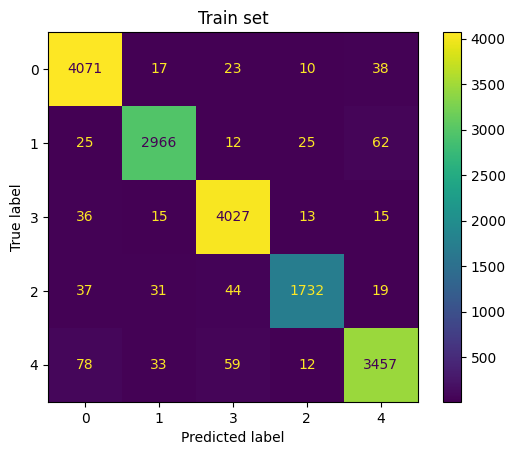

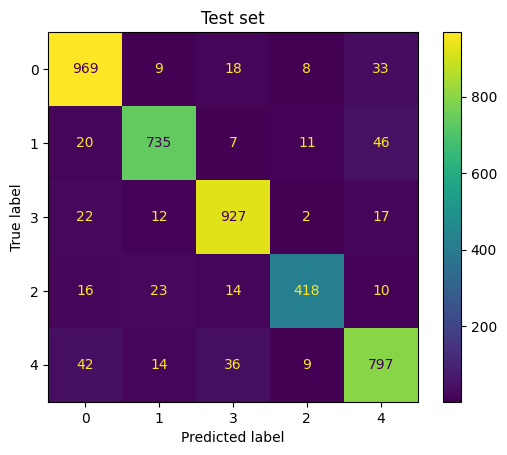

In [133]:
#running and evaluating the Logistic Regression model
params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300, 500, 1000],
    'class_weight': [None, 'balanced']
}

# model = grid_model(LogisticRegression(), params)
lr_model = random_search_model(LogisticRegression(random_state=42), params)
print('\n')
eval_model(y_train, lr_model.predict(X_train), lr_model.predict_proba(X_train), eval_type='Train')
print('\n')
eval_model(y_test, lr_model.predict(X_test), lr_model.predict_proba(X_test), eval_type='Test')

### 2. Decision Tree

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Model params : 

	 {'splitter': 'random', 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': 6, 'criterion': 'entropy'}


Train set results : 


	 Accuracy:  0.63
	 Precision:  0.65
	 Recall:  0.63
	 F1 Score:  0.63
	 ROC AUC Score:  0.87


	Classification Report: 

               precision    recall  f1-score   support

           0       0.67      0.74      0.70      4159
           1       0.67      0.75      0.71      3090
           2       0.82      0.56      0.66      4106
           3       0.59      0.51      0.55      1863
           4       0.47      0.56      0.51      3639

    accuracy                           0.63     16857
   macro avg       0.64      0.62      0.63     16857
weighted avg       0.65      0.63      0.63     16857





Test set results : 


	 Accuracy:  0.63
	 Precision:  0.65
	 Recall:  0.63
	 F1 Score:  0.63
	 ROC AUC Score:  0.87


	Classification Report

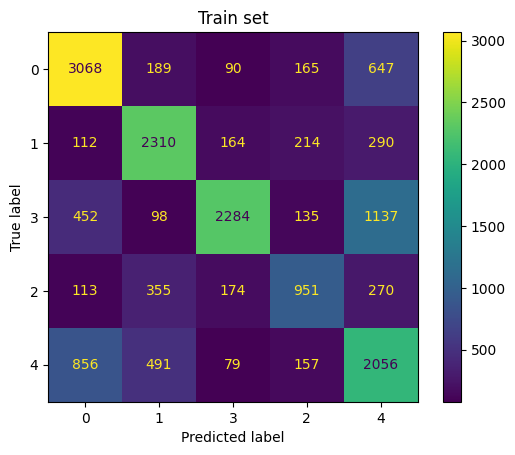

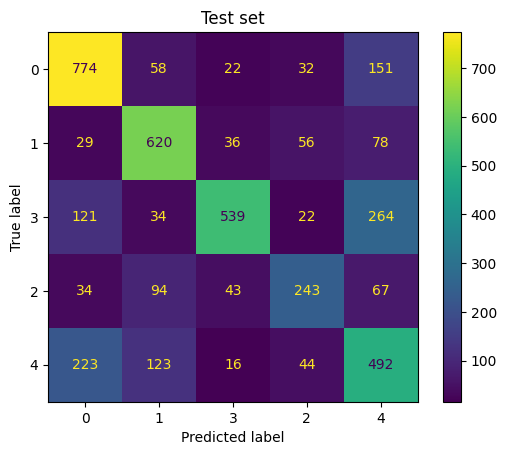

In [134]:
#running and evaluating the Decision Tree model
params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

dt_model = random_search_model(DecisionTreeClassifier(random_state=42), params)
print('\n')
eval_model(y_train, dt_model.predict(X_train), dt_model.predict_proba(X_train), eval_type='Train')
print('\n')
eval_model(y_test, dt_model.predict(X_test), dt_model.predict_proba(X_test), eval_type='Test')

### 3. Random Forest

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Model params : 

	 {'n_estimators': 100, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': True}


Train set results : 


	 Accuracy:  0.79
	 Precision:  0.81
	 Recall:  0.79
	 F1 Score:  0.78
	 ROC AUC Score:  0.97


	Classification Report: 

               precision    recall  f1-score   support

           0       0.71      0.96      0.82      4159
           1       0.90      0.56      0.69      3090
           2       0.76      0.94      0.84      4106
           3       0.97      0.51      0.67      1863
           4       0.84      0.75      0.79      3639

    accuracy                           0.79     16857
   macro avg       0.84      0.74      0.76     16857
weighted avg       0.81      0.79      0.78     16857





Test set results : 


	 Accuracy:  0.72
	 Precision:  0.75
	 Recall:  0.72
	 F1 Score:  0.7
	 ROC AUC Score:  0.95


	Cl

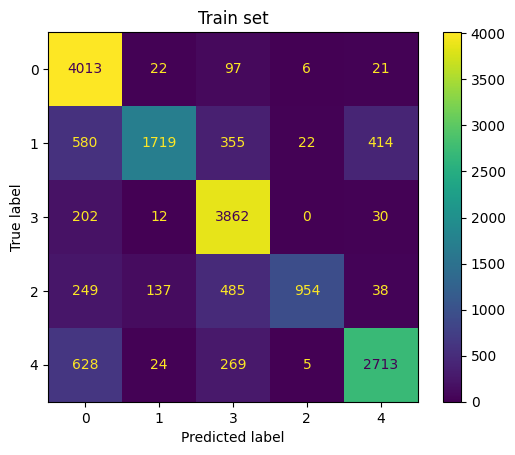

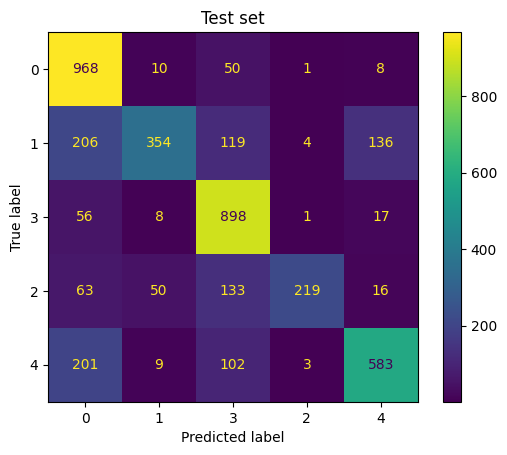

In [135]:
#running and evaluating the Random Forest model
params = {
    'n_estimators': [10, 50, 100, 200, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf_model = random_search_model(RandomForestClassifier(random_state=42), params)
print('\n')
eval_model(y_train, rf_model.predict(X_train), rf_model.predict_proba(X_train), eval_type='Train')
print('\n')
eval_model(y_test, rf_model.predict(X_test), rf_model.predict_proba(X_test), eval_type='Test')

### 4. Naive Bayes

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Model params : 

	 {'fit_prior': False, 'alpha': 0.1}


Train set results : 


	 Accuracy:  0.86
	 Precision:  0.86
	 Recall:  0.86
	 F1 Score:  0.86
	 ROC AUC Score:  0.98


	Classification Report: 

               precision    recall  f1-score   support

           0       0.86      0.91      0.88      4159
           1       0.83      0.78      0.81      3090
           2       0.89      0.89      0.89      4106
           3       0.81      0.85      0.83      1863
           4       0.86      0.83      0.85      3639

    accuracy                           0.86     16857
   macro avg       0.85      0.85      0.85     16857
weighted avg       0.86      0.86      0.86     16857





Test set results : 


	 Accuracy:  0.77
	 Precision:  0.76
	 Recall:  0.77
	 F1 Score:  0.76
	 ROC AUC Score:  0.95


	Classification Report: 

               precision    recall  f1-score   support

           0       0.77      0.84     

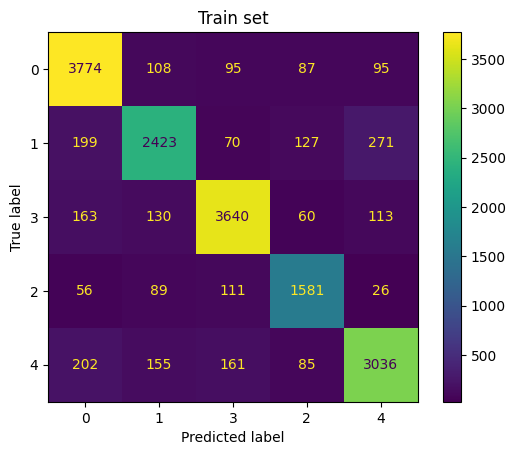

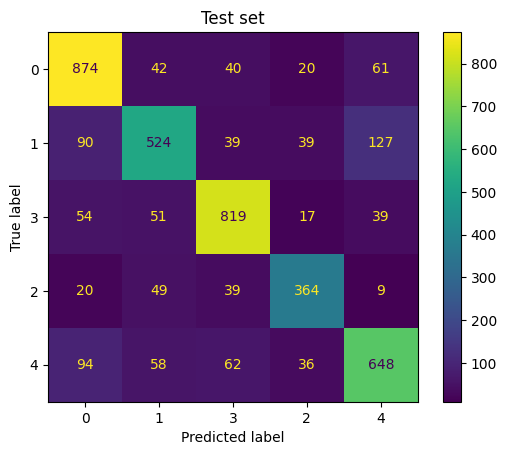

In [136]:
#running and evaluating the Gaussian Naive Bayes model
params = {
    'alpha': [0.1, 0.5, 1, 2, 5],
    'fit_prior': [True, False]
}

nb_model = random_search_model(MultinomialNB(), params)
print('\n')
eval_model(y_train, nb_model.predict(X_train), nb_model.predict_proba(X_train), eval_type='Train')
print('\n')
eval_model(y_test, nb_model.predict(X_test), nb_model.predict_proba(X_test), eval_type='Test')

## Model Results

|Model|Accuracy|Precision|Recall|F1 Score| ROC AUC Score|
|:-----:|:-----:|:-------:|:------:|:------:|:--------:|
|Logistic Regression| 0.91 | 0.91 | 0.91 | 0.91 | 0.99 |
|Decision Tree| 0.63 | 0.65 | 0.63 | 0.63 | 0.87 |
|Random Forest| 0.72 | 0.75 | 0.72 | 0.7 | 0.95 |
|Naive Bayes (Multinomial)| 0.77 | 0.76 | 0.77 | 0.76 | 0.95 |




## Conclusion

From the above results we can see that Logistic Regression is performing the best with an F1 score of 0.91 .

Hence will be using this model to predict the topics for the new complaints.

## Model Inference

In [58]:
def final_model():

      model = LogisticRegression(
                            penalty="l2", max_iter=100,
                            solver="saga", class_weight=None,
                            C=1, random_state=42)
      model.fit(X_train, y_train)

      return model

def predict_tag(text):

      Topic_names = {
          0: 'Bank Account services',
          1: 'Credit card or prepaid card',
          2: 'Others',
          3: 'Theft/Dispute Reporting',
          4: 'Mortgage/Loan'
      }

      X_new_counts = count_vect.transform(text)
      X_new_tfidf = tfidf_transformer.transform(X_new_counts)
      model = final_model()
      predicted = model.predict(X_new_tfidf)
      return Topic_names[predicted[0]]

In [65]:
df_test_complaints = pd.DataFrame({'complaints' : ["Can you please provide me the payment statement of my loan. ",
                                                   "My millinia card was reported on xx xx 2023. however fraudulent application have been submitted my identity without my consent to fraudulently obtain services. So please do not extend credit without verifying the identity of the applicant"
                                                   "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest. Thank You.",
                                                   "Please provide me the procedure to open a salary account at the XXX branch of your company.",
                                                   "I have received a fraudulent email regarding a transaction. Please help me with this regard.",
                                                   "How can I find out my CIBIL score?",]})



In [66]:
df_test_complaints['ticket_tag'] = df_test_complaints['complaints'].apply(lambda x: predict_tag([x]))
df_test_complaints

,complaints,ticket_tag
0,Can you please provide me the payment statement of my loan.,Others
1,My millinia card was reported on xx xx 2023. however fraudulent application have been submitted my identity without my consent to fraudulently obtain services. So please do not extend credit without verifying the identity of the applicantThe bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest. Thank You.,Credit card or prepaid card
2,Please provide me the procedure to open a salary account at the XXX branch of your company.,Bank Account services
3,I have received a fraudulent email regarding a transaction. Please help me with this regard.,Mortgage/Loan
4,How can I find out my CIBIL score?,Bank Account services
